In [1]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [2]:
import socceraction

In [3]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

# Set up the StatsBombLoader

In [4]:
# Use this if you want to use the free public statsbomb data
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

In [5]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [6]:
selected_competitions = competitions[competitions.competition_name == "UEFA Euro"]
selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
38,43,55,UEFA Euro,Europe,male,2020


In [7]:
# Get games from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,914,772,2021-07-06 21:00:00,1,1
1,796,776,2021-06-21 21:00:00,1,4
2,790,908,2021-06-18 15:00:00,1,0
3,914,907,2021-06-20 18:00:00,1,0
4,780,770,2021-06-19 18:00:00,2,4
5,780,771,2021-06-23 21:00:00,2,2
6,909,907,2021-06-16 18:00:00,0,2
7,914,773,2021-06-16 21:00:00,3,0
8,772,789,2021-06-19 21:00:00,1,1
9,785,912,2021-06-18 18:00:00,1,1


# Load and convert match data


In [8]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|██████████| 51/51 [02:56<00:00,  3.47s/it]


In [9]:
datafolder = "spadl-euro20"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

Directory spadl-euro20 created.


# Plot the spadl data


In [10]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select Italy vs Engalnd at Euro
    game = games[(games.competition_name == "UEFA Euro") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Italy")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,3795506,0aee931f-9614-4879-b3e8-fd9d7cc80c59,1,0.0,914,7788.0,52.058824,34.430380,42.794118,40.283544,0,1,0,0,pass,success,foot,Ciro Immobile,Italy
1,3795506,78b27402-d516-466f-9f33-20251b6079d1,1,0.0,914,3166.0,42.794118,40.283544,41.470588,38.131646,21,1,0,1,dribble,success,foot,Marco Verratti,Italy
2,3795506,9440989a-b1a0-4142-9907-1c9e69559ac7,1,2.0,914,3166.0,41.470588,38.131646,33.529412,8.005063,0,1,0,2,pass,success,foot,Marco Verratti,Italy
3,3795506,694576dc-66fb-4373-820a-119e6c36da84,1,3.0,914,11514.0,33.529412,8.005063,33.705882,9.984810,21,1,0,3,dribble,success,foot,Giovanni Di Lorenzo,Italy
4,3795506,7cc5e22d-caff-46b1-8adf-fb1f3e3bdc1e,1,5.0,914,11514.0,33.705882,9.984810,21.088235,28.663291,0,1,0,4,pass,success,foot,Giovanni Di Lorenzo,Italy


In [11]:
games.sort_values(by=['game_date'], inplace=True)
games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee,competition_name,country_name,competition_gender,season_name,home_team_name,away_team_name
11,3788741,43,55,Group Stage,1,2021-06-11 21:00:00,909,914,0,3,Estadio Olímpico,Danny Desmond Makkelie,UEFA Euro,Europe,male,2020,Turkey,Italy
50,3788744,43,55,Group Stage,1,2021-06-12 15:00:00,907,773,1,1,Bakı Olimpiya Stadionu,Clément Turpin,UEFA Euro,Europe,male,2020,Wales,Switzerland
46,3788742,43,55,Group Stage,1,2021-06-12 18:00:00,776,1835,0,1,Parken,Anthony Taylor,UEFA Euro,Europe,male,2020,Denmark,Finland
49,3788743,43,55,Group Stage,1,2021-06-12 21:00:00,782,796,3,0,Saint-Petersburg Stadium,Antonio Miguel Mateu Lahoz,UEFA Euro,Europe,male,2020,Belgium,Russia
33,3788745,43,55,Group Stage,1,2021-06-13 15:00:00,768,785,1,0,Wembley Stadium,Daniele Orsato,UEFA Euro,Europe,male,2020,England,Croatia
10,3788747,43,55,Group Stage,1,2021-06-13 18:00:00,915,2358,3,1,Arena Naţională,Lars Christian Andreas Ekberg,UEFA Euro,Europe,male,2020,Austria,North Macedonia
37,3788746,43,55,Group Stage,1,2021-06-13 21:00:00,941,911,3,2,Johan Cruijff Arena (Amsterdam),Felix Brych,UEFA Euro,Europe,male,2020,Netherlands,Ukraine
43,3788748,43,55,Group Stage,1,2021-06-14 15:00:00,942,912,0,2,Hampden Park,Daniel Siebert,UEFA Euro,Europe,male,2020,Scotland,Czech Republic
41,3788749,43,55,Group Stage,1,2021-06-14 18:00:00,789,908,1,2,Saint-Petersburg Stadium,Ovidiu Alin Hațegan,UEFA Euro,Europe,male,2020,Poland,Slovakia
42,3788750,43,55,Group Stage,1,2021-06-14 21:00:00,772,790,0,0,Estadio de La Cartuja,Slavko Vinčić,UEFA Euro,Europe,male,2020,Spain,Sweden


In [12]:
goals = actions[(actions.type_name == 'shot') & (actions.result_name == 'success')]
goals

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
39,3795506,6605af47-8d44-4f52-9b8d-65598a9c0ef1,1,117.0,768,3382.0,6.088235,25.650633,0.0,30.987342,11,1,0,39,shot,success,foot,Luke Shaw,England
1568,3795506,a221a567-b43e-45d6-97f2-07b1cab75d21,2,1277.0,914,7173.0,103.676471,35.979747,105.0,36.840506,11,1,0,1568,shot,success,foot,Leonardo Bonucci,Italy


2021-07-11 21:00:00 Italy 1-1 England 66'


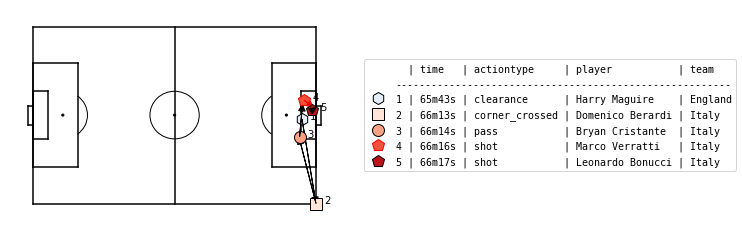

In [13]:
import matplotsoccer

# Select the 5 actions preceding the 1-1 (the goal is 1568)
shot = 1568
a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)

In [14]:
import socceraction.vaep.features as fs
import socceraction.vaep.labels as lab

# Select Data

In [15]:
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder, "features.h5")
labels_h5 = os.path.join(datafolder, "labels.h5")

In [16]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

nb of games: 51


# Compute features

VAEP is based on the insight that players tend to perform actions with two possible intentions:
1. increase the chance of scoring a goal in the short-term future and/or,
2. decrease the chance of conceding a goal in the short-term future.
Valuing an action then requires assessing the change in probability for both scoring and conceding as a result of an
action. Thus, VAEP values a game state as:
𝑉 (𝑆𝑖) = 𝑃𝑠𝑐𝑜𝑟𝑒(𝑆𝑖, 𝑡) − 𝑃𝑐𝑜𝑛𝑐𝑒𝑑𝑒(𝑆𝑖, 𝑡),
where 𝑃𝑠𝑐𝑜𝑟𝑒(𝑆𝑖, 𝑡) and 𝑃𝑐𝑜𝑛𝑐𝑒𝑑𝑒(𝑆𝑖, 𝑡) are the probabilities that team 𝑡 which possesses the ball in state 𝑆𝑖 will respectively
score or concede in the next 10 actions.


The remaining challenge is to “learn” 𝑃𝑠𝑐𝑜𝑟𝑒(𝑆𝑖, 𝑡) and 𝑃𝑐𝑜𝑛𝑐𝑒𝑑𝑒(𝑆𝑖, 𝑡). That is, a gradient boosted binary classifier
is trained on historical data to predict how a game state will turn out based on what happened in similar game states
that arose in past games. VAEP also uses a more complex representation of the game state: it considers the three last
actions that happened during the game: 𝑆𝑖 = {𝑎𝑖−2, 𝑎𝑖1, 𝑎𝑖}. With the code below, you can convert the SPADL action
of the game to these game states:


Then each game state is represented using three types of features. The first category of features includes characteristics
of the action itself such as its location and type as well as more complex relationships such as the distance and angle
to the goal. The second category of features captures the context of the action, such as the current tempo of the game,
by comparing the properties of consecutive actions. Examples of this type of feature include the distance covered and
time elapsed between consecutive actions. The third category of features captures the current game context by looking
at things such as the time remaining in the match and the current score differential. 


In [17]:
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.result,
    fs.result_onehot,
    fs.goalscore,
    fs.startlocation,
    fs.endlocation,
    fs.movement,
    fs.space_delta,
    fs.startpolar,
    fs.endpolar,
    fs.team,
    fs.time,
    fs.time_delta
]

for game in tqdm.tqdm(list(games.itertuples()), desc=f"Generating and storing features in {features_h5}"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    gamestates = fs.gamestates(spadl.add_names(actions), 3)
    gamestates = fs.play_left_to_right(gamestates, game.home_team_id)
    
    X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
    X.to_hdf(features_h5, f"game_{game.game_id}")

Generating and storing features in spadl-euro20/features.h5: 100%|██████████| 51/51 [00:16<00:00,  3.18it/s]



For estimating 𝑃𝑠𝑐𝑜𝑟𝑒(𝑆𝑖, 𝑡), each game state is given a positive label (= 1) if the team that possesses the ball after action
𝑎𝑖 scores a goal in the subsequent 𝑘 actions. Otherwise, a negative label (= 0) is given to the game state. Analogously,
for estimating 𝑃𝑐𝑜𝑛𝑐𝑒𝑑𝑒(𝑆𝑖, 𝑡), each game state is given a positive label (= 1) if the team that possesses the ball after
action 𝑎𝑖 concedes a goal in the subsequent 𝑘 actions. If not, a negative label (= 0) is given to the game state.



# Compute labels

In [18]:
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")   
    Y = pd.concat([fn(spadl.add_names(actions)) for fn in yfns], axis=1)
    Y.to_hdf(labels_h5, f"game_{game.game_id}")

Computing and storing labels in spadl-euro20/labels.h5: 100%|██████████| 51/51 [00:13<00:00,  3.89it/s]


VAEP models the scoring and conceding probabilities separately as these effects may be asymmetric in nature and
context-dependent. Hence, it trains one gradient boosted tree model to predict each one based on the current game
state.

In [19]:
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [21]:
games.loc[0:12]

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3795220,43,55,Semi-finals,6,2021-07-06 21:00:00,914,772,1,1,Wembley Stadium,Felix Brych
1,3788769,43,55,Group Stage,3,2021-06-21 21:00:00,796,776,1,4,Parken,Clément Turpin
2,3788761,43,55,Group Stage,2,2021-06-18 15:00:00,790,908,1,0,Saint-Petersburg Stadium,Daniel Siebert
3,3788766,43,55,Group Stage,3,2021-06-20 18:00:00,914,907,1,0,Estadio Olímpico,Ovidiu Alin Hațegan
4,3788764,43,55,Group Stage,2,2021-06-19 18:00:00,780,770,2,4,Allianz Arena,Anthony Taylor
5,3788773,43,55,Group Stage,3,2021-06-23 21:00:00,780,771,2,2,Puskás Aréna,Antonio Miguel Mateu Lahoz
6,3788755,43,55,Group Stage,2,2021-06-16 18:00:00,909,907,0,2,Bakı Olimpiya Stadionu,Artur Manuel Ribeiro Soares Dias
7,3788754,43,55,Group Stage,2,2021-06-16 21:00:00,914,773,3,0,Estadio Olímpico,Sergey Karasev
8,3788762,43,55,Group Stage,2,2021-06-19 21:00:00,772,789,1,1,Estadio de La Cartuja,Daniele Orsato
9,3788760,43,55,Group Stage,2,2021-06-18 18:00:00,785,912,1,1,Hampden Park,Carlos del Cerro Grande


In [22]:
traingames = games.loc[13:]
testgames = games.loc[0:12]

In [23]:
# 1. Select feature set X
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.result,
    fs.result_onehot,
    fs.goalscore,
    fs.startlocation,
    fs.endlocation,
    fs.movement,
    fs.space_delta,
    fs.startpolar,
    fs.endpolar,
    fs.team,
    #fs.time,
    fs.time_delta,
    #fs.actiontype_result_onehot
]
nb_prev_actions = 1

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games,Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.read_hdf(features_h5, f"game_{game_id}")
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores","concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.read_hdf(labels_h5, f"game_{game_id}")
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

X, Y = getXY(traingames,Xcols)
print("X:", list(X.columns))
print("Y:", list(Y.columns))

Selecting label: 100%|██████████| 38/38 [00:00<00:00, 95.13it/s] 


X: ['type_id_a0', 'type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'bodypart_foot_a0', 'bodypart_head_a0', 'bodypart_other_a0', 'bodypart_head/other_a0', 'result_id_a0', 'result_fail_a0', 'result_success_a0', 'result_offside_a0', 'result_owngoal_a0', 'result_yellow_card_a0', 'result_red_card_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'start_x_a0', 'start_y_a0', 'end_x_a0', 'end_y_a0', 'dx_a0', 'dy_a0', 'movement_a0', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'end_dist_to_goal_a0', 'end_angle_to_goal_a0']
Y: ['scores

# Train a model


In [24]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1)
    model.fit(X, Y[col])
    models[col] = model

CPU times: user 18.1 s, sys: 408 ms, total: 18.5 s
Wall time: 18.9 s


In [25]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

testX, testY = X, Y

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)]
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

### Y: scores ###
  Brier score: 0.00837 (0.80908)
  log loss score: 0.04019 (0.69185)
  ROC AUC: 0.89075
### Y: concedes ###
  Brier score: 0.00149 (0.80603)
  log loss score: 0.00777 (0.57410)
  ROC AUC: 0.97256


# Save predictions


In [28]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading game ids"):
    Ai = pd.read_hdf(spadl_h5, f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k, df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 51/51 [00:00<00:00, 62.35it/s]


# compute VAEP values and top players

Using these probabilities, VAEP defines the offensive value of an action as the change in scoring probability before and
after the action.

𝑃score(𝑎𝑖, 𝑡) = 𝑃score(𝑆𝑖, 𝑡) − 𝑃𝑘 score(𝑆𝑖−1, 𝑡)

This change will be positive if the action increased the probability that the team which performed the action will score
(e.g., a successful tackle to recover the ball). Similarly, VAEP defines the defensive value of an action as the change in
conceding probability.

𝑃concede(𝑎𝑖, 𝑡) = 𝑃𝑘 concede(𝑆𝑖, 𝑡) − 𝑃𝑘 concede(𝑆𝑖−1, 𝑡)

This change will be positive if the action increased the probability that the team will concede a goal (e.g., a failed pass).
Finally, the total VAEP value of an action is the difference between that action’s offensive value and defensive value.

𝑉VAEP(𝑎𝑖) = 𝑃score(𝑎𝑖, 𝑡) − 𝑃concede(𝑎𝑖, 𝑡)

In [27]:
import socceraction.vaep.formula as vaepformula

In [29]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 51


# Compute VAEP values


In [30]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 51/51 [00:06<00:00,  7.58it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

# Analyse VAEP ratings

## Most valuable players


In [31]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
75,4706.0,Kalvin Phillips,3.434241,2.550701,0.883541,674
372,18617.0,Mykola Matvienko,2.905979,1.307748,1.598232,763
203,7173.0,Leonardo Bonucci,2.769714,2.433354,0.336360,917
470,38196.0,"Daniel O""Shaughnessy",2.708350,1.416414,1.291936,287
30,3325.0,Marko Arnautović,2.587418,1.537368,1.050050,165
41,3500.0,Granit Xhaka,2.498451,2.185812,0.312639,607
60,3943.0,Declan Rice,2.277311,1.533707,0.743604,657
317,11514.0,Giovanni Di Lorenzo,2.240558,1.238240,1.002319,678
364,16570.0,Vladimír Coufal,2.236614,1.574457,0.662157,629
33,3382.0,Luke Shaw,2.231523,1.630576,0.600947,748


In [32]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
30,3325.0,Marko Arnautović,2.587418,1.537368,1.050050,165,231,1.008085,0.598974,0.409110
470,38196.0,"Daniel O""Shaughnessy",2.708350,1.416414,1.291936,287,292,0.834765,0.436566,0.398200
207,7693.0,Bruno Petković,1.409900,1.255140,0.154760,134,183,0.693394,0.617282,0.076112
157,6307.0,Duje Ćaleta-Car,1.581055,1.267185,0.313870,189,223,0.638094,0.511420,0.126674
161,6332.0,Thomas Vermaelen,2.137805,1.816399,0.321406,363,308,0.624683,0.530766,0.093917
53,3621.0,Eden Hazard,1.554265,1.540992,0.013274,334,240,0.582850,0.577872,0.004978
342,16027.0,Kevin Mbabu,1.495963,1.289288,0.206675,229,233,0.577840,0.498008,0.079832
41,3500.0,Granit Xhaka,2.498451,2.185812,0.312639,607,414,0.543142,0.475176,0.067965
104,5461.0,Šime Vrsaljko,1.127616,0.851876,0.275741,232,189,0.536960,0.405655,0.131305
185,6990.0,Milan Škriniar,1.717050,0.523609,1.193442,353,289,0.534722,0.163062,0.371660


## (optional) inspect Italy's top 10 most valuable non-shot actions


2021-06-20 18:00:00 Italy 1-0 Wales 2' pass Leonardo Bonucci


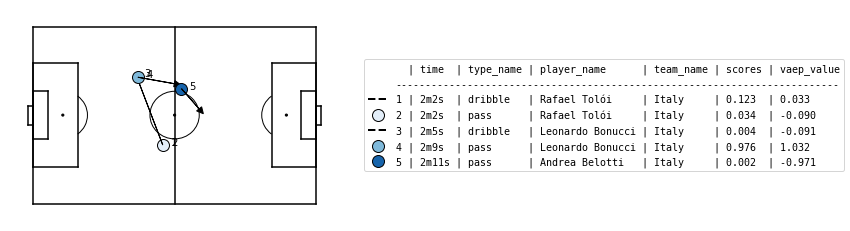

2021-07-11 21:00:00 Italy 1-1 England 151' pass Leonardo Bonucci


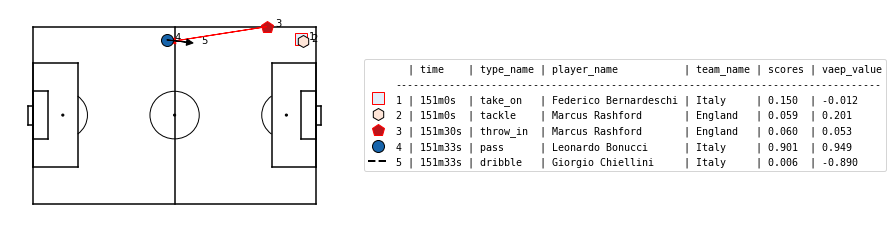

2021-07-11 21:00:00 Italy 1-1 England 52' dribble Ciro Immobile


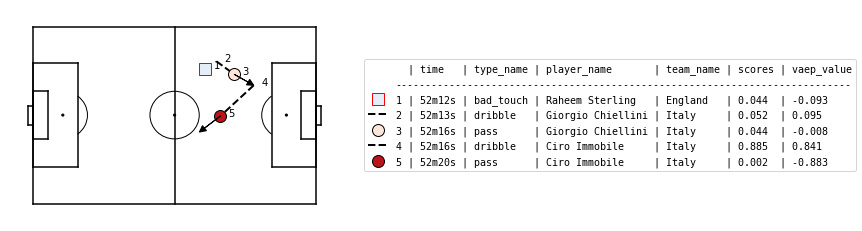

2021-07-06 21:00:00 Italy 1-1 Spain 5' dribble Emerson Palmieri dos Santos


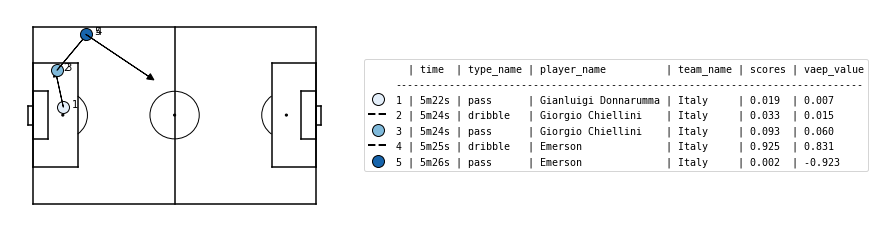

2021-06-11 21:00:00 Turkey 0-3 Italy 87' dribble Nicolò Barella


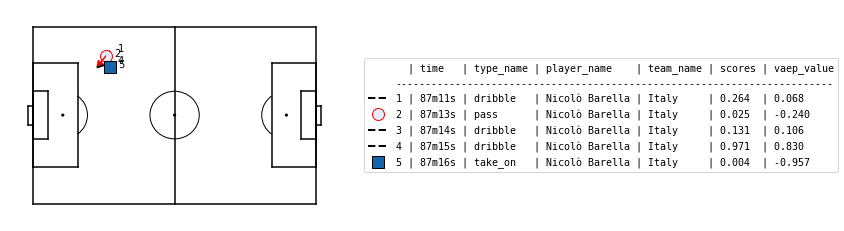

2021-06-26 21:00:00 Italy 2-1 Austria 83' pass Federico Chiesa


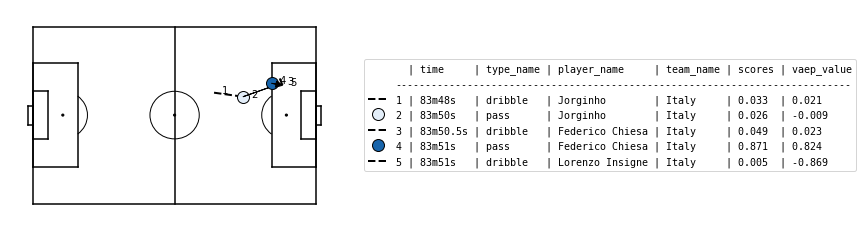

2021-06-16 21:00:00 Italy 3-0 Switzerland 90' dribble Giovanni Di Lorenzo


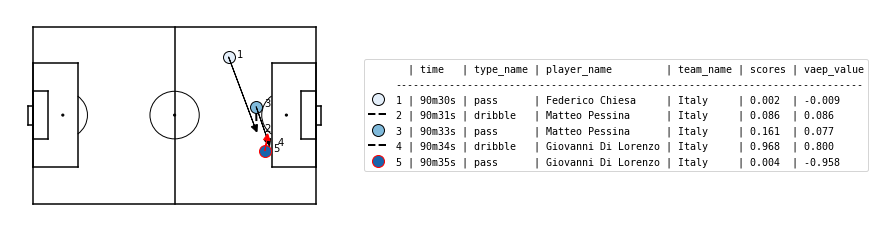

2021-06-20 18:00:00 Italy 1-0 Wales 41' dribble Emerson Palmieri dos Santos


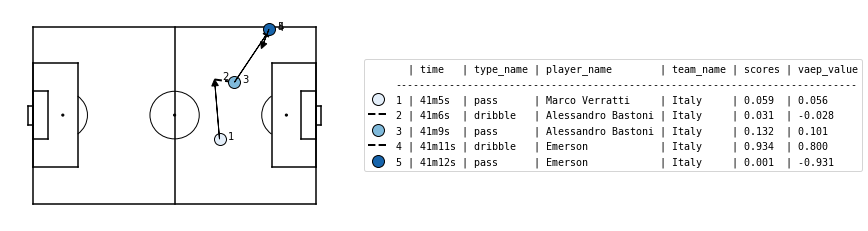

2021-07-11 21:00:00 Italy 1-1 England 76' dribble Marco Verratti


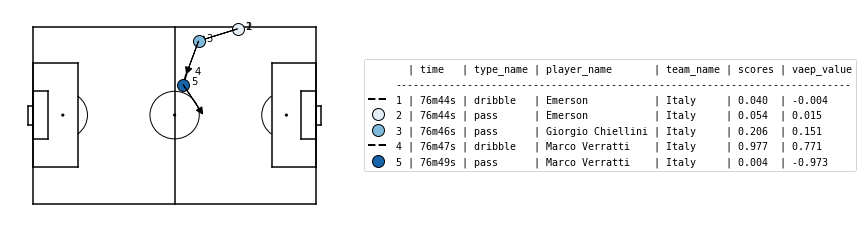

2021-06-11 21:00:00 Turkey 0-3 Italy 11' pass Leonardo Bonucci


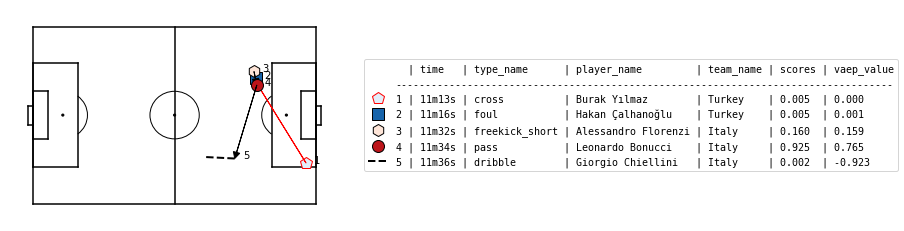

In [33]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Italy"] # view only actions from Italy
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)

# <span style="color: red;"> Atomic-VAEP </span>

When building models to value actions, a heavy point of debate is how to handle the results of actions. In other words,
should our model make a distinction between a failed and a successful pass or not? On the one hand, an action should
be valued on all its properties, and whether or not the action was successful (e.g., did a pass receive a teammate, was a
shot converted into a goal) plays a crucial role in how useful the action was. That is, if you want to measure a player’s
contribution during a match, successful actions are important. This is the viewpoint of SPADL and VAEP.

On the other hand, including the result of an action intertwines the contribution of the player who started the action
(e.g., provides the pass) and the player who completes it (e.g., receives the pass). Perhaps a pass was not successful
because of its recipient’s poor touch or because he was not paying attention. It would seem unfair to penalize the player
who provided the pass in such a circumstance. Hence, it can be useful to generalize over possible results of an action
to arrive at an action’s “expected value”.

The combination of Atomic-SPADL and VAEP accomodates this alternative viewpoint. Atomic-SPADL removes the
“result” attribute from SPADL and adds a few new action and event types. This affects the features that can be computed to represent each game state.

The computation of the labels and the VAEP formula are similar to the standard VAEP model.

Empirically, we have noticed two benefits of using the Atomic-SPADL representation. First, the standard SPADL
representation tends to assign shots a value that is the difference between the shot’s true outcome and its xG score.
Hence, goals or a number of misses, particularly for players who do not take a lot of shots can have an outsized effect
on their VAEP score. In contrast, Atomic-SPADL assigns shots a value closer to their xG score, which often better
matches domain experts’ intuitions on action values.

Second, Atomic-SPADL leads to more robust action values and player ratings. A good rating system should capture
the true quality of all players. Although some fluctuations in performances are possible across games, over the course
of a season a few outstanding performances (possibly stemming from a big portion of luck) should not dramatically
alter an assessment of a player. In our prior work comparing VAEP to xT, one advantage of xT was that it produced
more stable ratings. Using Atomic-SPADL helps alleviate this weakness.

In [34]:
import socceraction.atomic.spadl as atomicspadl

# <span style="color: red;"> Load and convert match data </span>

In [35]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
atomic_actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    
    # convert data
    actions = spadl.statsbomb.convert_to_actions(events, game.home_team_id)
    atomic_actions[game.game_id] = atomicspadl.convert_to_atomic(actions)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|██████████| 51/51 [03:10<00:00,  3.73s/it]


In [36]:
datafolder = "atomic-spadl-euro20"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in atomic_actions.keys():
        spadlstore[f"atomic_actions/game_{game_id}"] = atomic_actions[game_id]

Directory atomic-spadl-euro20 created.


# <span style="color: red;"> Plot the spadl data </span>

In [37]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select Italy vs Engalnd at Euro
    game = games[(games.competition_name == "UEFA Euro") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Italy")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"atomic_actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,3788744,1969229c-b8bb-409d-ab30-db6ca6d5f08f,1,0.0,773,3533.0,52.058824,33.655696,74.911765,22.293671,0,1,0,0
1,3788744,716e2373-2b0f-4f48-9edf-a696114d4e0e,1,2.0,773,5549.0,74.911765,22.293671,73.411765,22.637975,21,1,0,1
2,3788744,868d33a4-d1ac-45d4-a7bd-268c4dbac0d8,1,3.0,773,5549.0,73.411765,22.637975,23.911765,53.453165,0,0,0,2
3,3788744,927f1f58-96c8-43bf-acce-5b91b5051916,1,7.0,907,11250.0,23.117647,54.227848,34.852941,53.453165,0,1,0,3
4,3788744,9a96969c-4f64-475d-a32b-8bb86b0ad091,1,8.0,907,3517.0,34.852941,53.453165,36.176471,51.817722,21,1,0,4


2021-07-11 21:00:00 Italy 1-1 England 2'


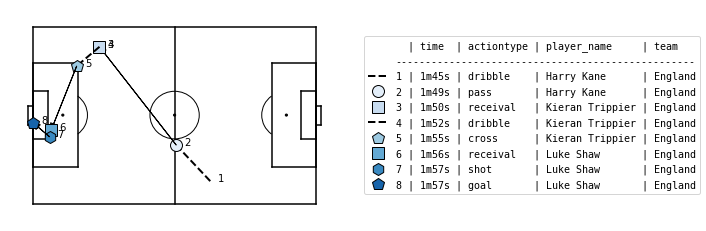

2021-07-11 21:00:00 Italy 1-1 England 66'


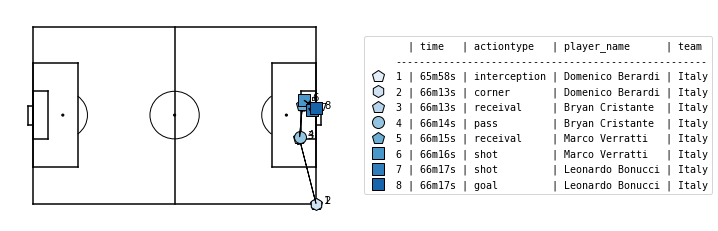

2021-07-11 21:00:00 Italy 1-1 England 153'


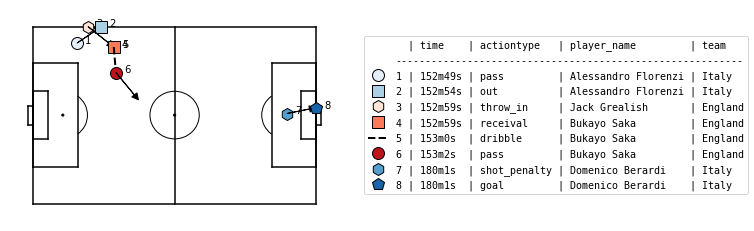

2021-07-11 21:00:00 Italy 1-1 England 153'


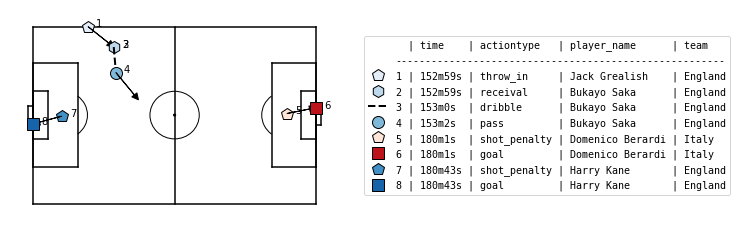

2021-07-11 21:00:00 Italy 1-1 England 154'


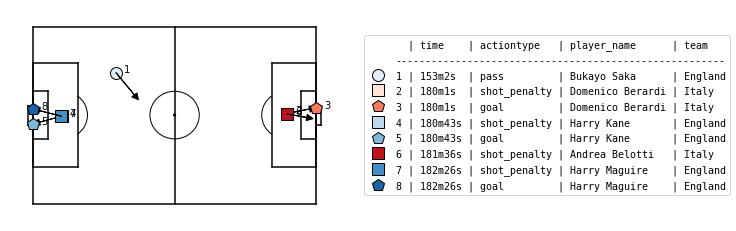

2021-07-11 21:00:00 Italy 1-1 England 181'


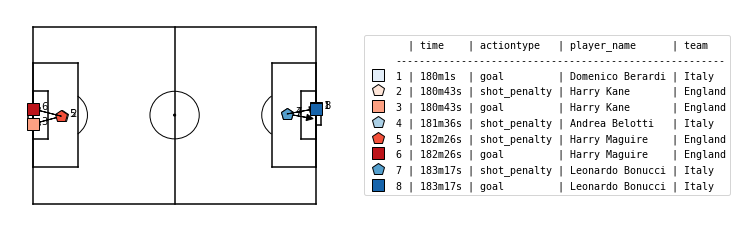

2021-07-11 21:00:00 Italy 1-1 England 182'


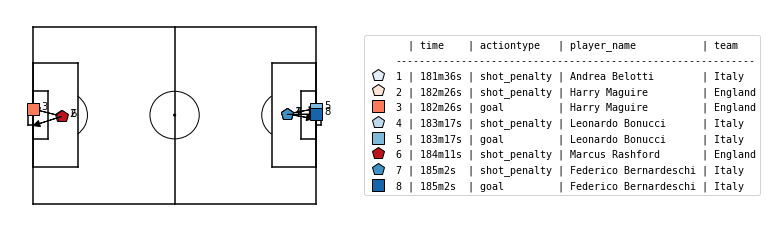

In [38]:
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

In [39]:
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

# <span style="color: red;"> Select the data </span>

In [40]:
spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")
features_h5 = os.path.join(datafolder, "atomic-features.h5")
labels_h5 = os.path.join(datafolder, "atomic-labels.h5")
predictions_h5 = os.path.join(datafolder, "atomic-predictions.h5")

In [41]:
games = pd.read_hdf(spadl_h5, "games")
print("nb of games:", len(games))

nb of games: 51


# <span style="color: red;"> Compute features </span>

In [42]:
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(features_h5) as featurestore:
    for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {features_h5}"):
        actions = spadlstore[f"atomic_actions/game_{game.game_id}"]
        gamestates = fs.gamestates(atomicspadl.add_names(actions), 2)
        gamestates = fs.play_left_to_right(gamestates, game.home_team_id)

        X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
        featurestore[f"game_{game.game_id}"] = X

Generating and storing features in atomic-spadl-euro20/atomic-features.h5: 100%|██████████| 51/51 [00:11<00:00,  4.52it/s]


# <span style="color: red;"> Compute labels </span>

In [43]:
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"atomic_actions/game_{game.game_id}"]
        Y = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore[f"game_{game.game_id}"] = Y

Computing and storing labels in atomic-spadl-euro20/atomic-labels.h5: 100%|██████████| 51/51 [00:12<00:00,  3.96it/s]


In [52]:
traingames = games
testgames = games

In [53]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 1

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.read_hdf(features_h5, f"game_{game_id}")
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.read_hdf(labels_h5, f"game_{game_id}")
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

X,Y = getXY(traingames, Xcols)
print("X:", list(X.columns))
print("Y:", list(Y.columns))
X = X.fillna(0)

Selecting label: 100%|██████████| 51/51 [00:00<00:00, 78.89it/s]


X: ['type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'type_receival_a0', 'type_out_a0', 'type_offside_a0', 'type_goal_a0', 'type_owngoal_a0', 'type_yellow_card_a0', 'type_red_card_a0', 'type_corner_a0', 'type_freekick_a0', 'bodypart_foot_a0', 'bodypart_head_a0', 'bodypart_other_a0', 'bodypart_head/other_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'x_a0', 'y_a0', 'dist_to_goal_a0', 'angle_to_goal_a0', 'dx_a0', 'dy_a0', 'period_id_a0', 'time_seconds_a0', 'time_seconds_overall_a0']
Y: ['scores', 'concedes']


# <span style="color: red;"> Train a model </span>

In [54]:
%%time
# train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    print(col)
    model = xgboost.XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1)
    model.fit(X, Y[col])
    models[col] = model

scores
concedes
CPU times: user 32.6 s, sys: 279 ms, total: 32.9 s
Wall time: 33.2 s


# <span style="color: red;"> Evaluate the model </span>

In [55]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

testX, testY = X, Y

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)]
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])

### Y: scores ###
  Brier score: 0.00575 (0.74599)
  log loss score: 0.02696 (0.59272)
  ROC AUC: 0.93789
### Y: concedes ###
  Brier score: 0.00096 (0.65796)
  log loss score: 0.00501 (0.45486)
  ROC AUC: 0.98478


# <span style="color: red;"> Save predictions </span>

In [56]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(testgames.game_id, "Loading actions of each game"):
    Ai = pd.read_hdf(spadl_h5, f"atomic_actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 51/51 [00:00<00:00, 61.56it/s]


In [57]:
import socceraction.atomic.vaep.formula as vaepformula

# <span style="color: red;"> Select the data </span>

In [58]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 51


# <span style="color: red;"> Compute VAEP values </span>

In [59]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.read_hdf(spadl_h5, f"atomic_actions/game_{game.game_id}")
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 51/51 [00:05<00:00,  9.54it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name', 'scores', 'concedes', 'offensive_value', 'defensive_value',
       'vaep_value'],
      dtype='object')

In [60]:
# Use this if you want to assign credit for the receival back to the initial passer
# A["player_id"] = A.player_id.mask(A.type_name == "receival", A.player_id.shift(1))

# <span style="color: red;"> Analyze VAEP ratings </span>

# <span style="color: red;"> Most valuable players </span>

In [61]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
196,7044.0,Patrik Schick,6.153141,6.029138,0.124004,380
23,3289.0,Romelu Lukaku,5.146131,4.955546,0.190585,363
20,3233.0,Raheem Sterling,5.134040,4.984343,0.149697,811
300,10955.0,Harry Kane,4.653924,5.683208,-1.029285,615
141,5625.0,Emil Peter Forsberg,4.507654,4.238729,0.268925,518
96,5207.0,Cristiano Ronaldo,4.256700,4.190269,0.066431,456
46,3567.0,Georginio Wijnaldum,4.086691,3.780383,0.306309,450
382,19677.0,Karim Benzema,4.056921,3.988773,0.068148,471
122,5543.0,Haris Seferović,3.821372,3.700075,0.121297,339
148,5668.0,Robert Lewandowski,3.791121,3.704254,0.086867,261


In [62]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
196,7044.0,Patrik Schick,6.153141,6.029138,0.124004,380,412,1.344133,1.317045,0.027088
156,6302.0,Kasper Dolberg,3.234113,3.177863,0.056250,206,230,1.265522,1.243512,0.022011
148,5668.0,Robert Lewandowski,3.791121,3.704254,0.086867,261,288,1.184725,1.157579,0.027146
167,6685.0,Mikel Oyarzabal,2.450794,1.923970,0.526823,338,194,1.136966,0.892563,0.244403
141,5625.0,Emil Peter Forsberg,4.507654,4.238729,0.268925,518,384,1.056481,0.993452,0.063029
382,19677.0,Karim Benzema,4.056921,3.988773,0.068148,471,368,0.992182,0.975515,0.016667
23,3289.0,Romelu Lukaku,5.146131,4.955546,0.190585,363,471,0.983337,0.946920,0.036418
96,5207.0,Cristiano Ronaldo,4.256700,4.190269,0.066431,456,390,0.982315,0.966985,0.015330
109,5474.0,Ivan Perišić,2.923876,2.356622,0.567254,326,271,0.971029,0.782642,0.188387
46,3567.0,Georginio Wijnaldum,4.086691,3.780383,0.306309,450,384,0.957818,0.886027,0.071791


##  <span style="color: red;"> (optional) inspect Italy's top 10 most valuable non-shot actions </span> 


2021-06-26 21:00:00 Italy 2-1 Austria 104' receival 11514.0


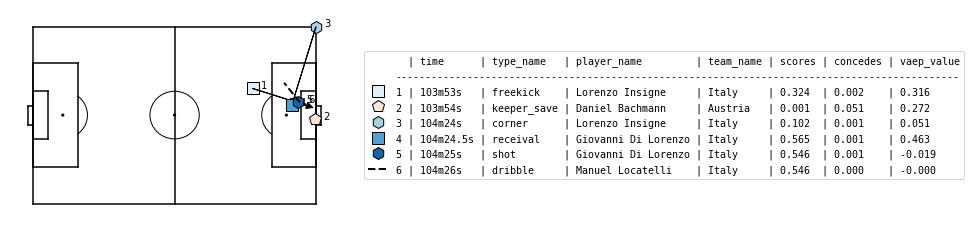

2021-06-16 21:00:00 Italy 3-0 Switzerland 61' dribble 7788.0


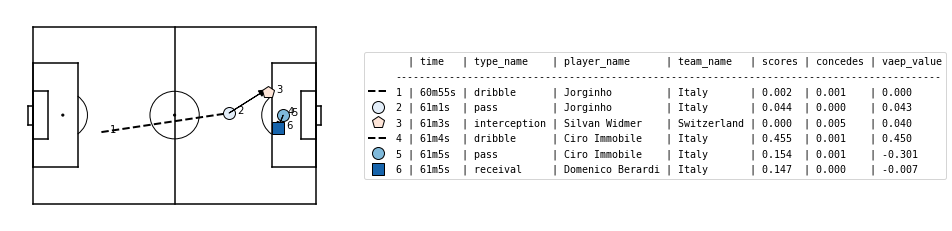

2021-06-26 21:00:00 Italy 2-1 Austria 104' receival 7119.0


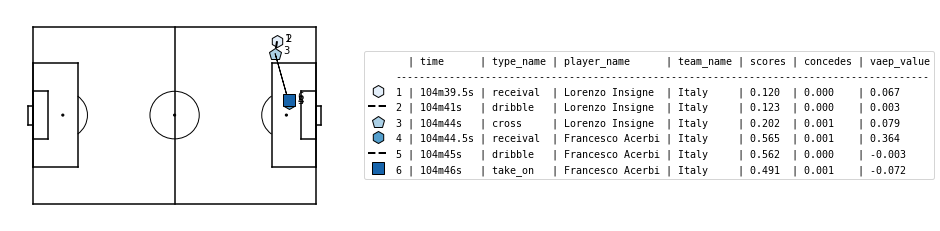

2021-06-26 21:00:00 Italy 2-1 Austria 103' freekick 7037.0


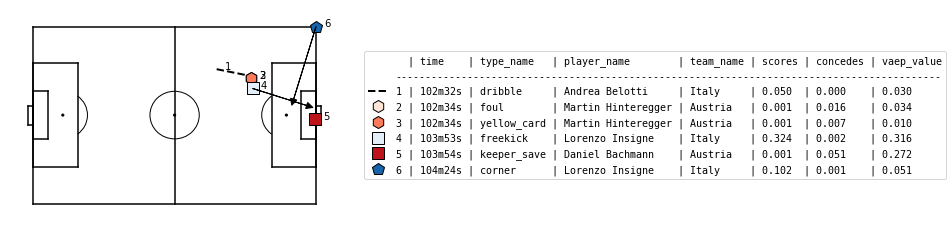

2021-07-11 21:00:00 Italy 1-1 England 152' cross 7131.0


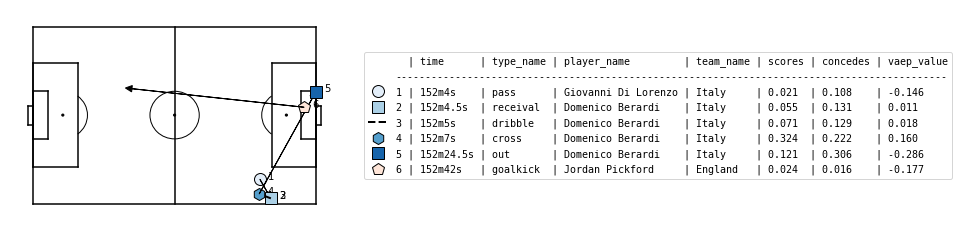

2021-06-26 21:00:00 Italy 2-1 Austria 104' dribble 11601.0


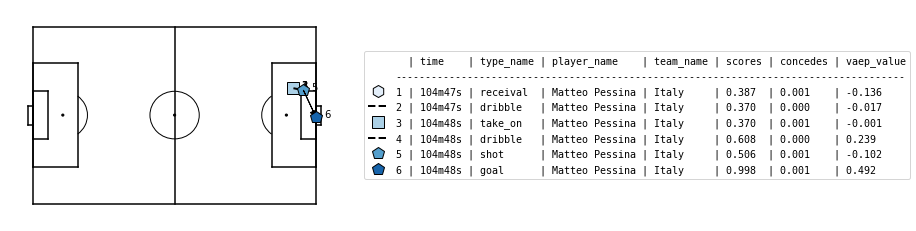

2021-07-11 21:00:00 Italy 1-1 England 152' out 6964.0


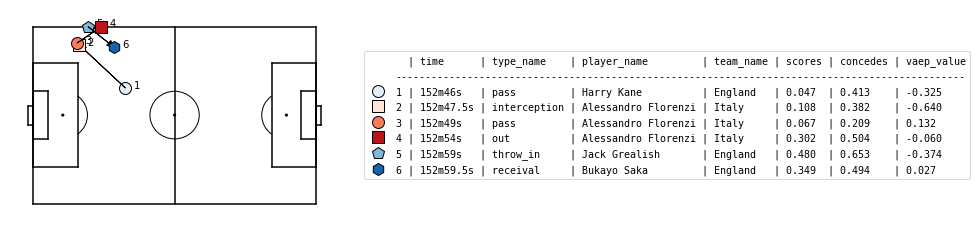

2021-06-16 21:00:00 Italy 3-0 Switzerland 25' receival 7038.0


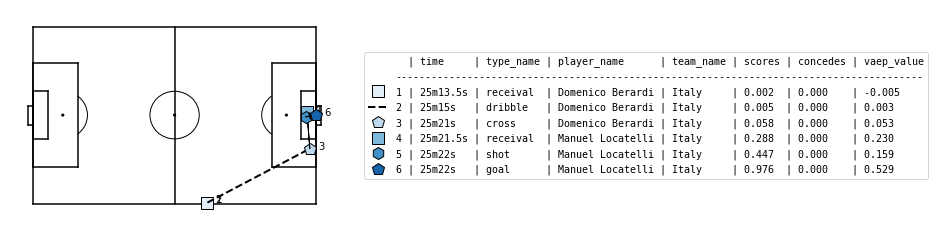

2021-06-26 21:00:00 Italy 2-1 Austria 94' dribble 7156.0


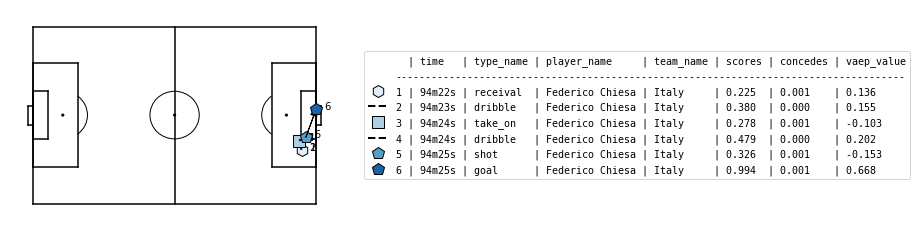

2021-07-11 21:00:00 Italy 1-1 England 56' dribble 7037.0


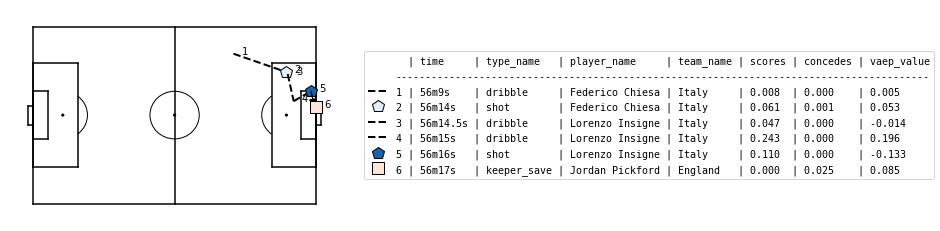

In [63]:
import matplotsoccer

sorted_A = A.sort_values("offensive_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Italy"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.isin(["goal", "shot", "shot_penalty"])] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1) * 45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i + 3].copy()
    
    a["player_name"] = a[["nickname" ,"player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id - 1) * 45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_id}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "concedes", "vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x", "y", "end_x", "end_y"]],
                a.type_name,
                team=a.team_name,
                label=a[cols],
                labeltitle = cols,
                zoom=False)